# Diagnosing Potential Predictability

This demo demonstrates `climpred`'s capabilities to diagnose areas containing potentially predictable variations from a control/verification product alone without requiring multi-member, multi-initialization simulations. This notebook identifies the slow components of internal variability that indicate potential predictability. Here, we showcase a set of methods to show regions indicating probabilities for decadal predictability.

In [1]:
import warnings
%matplotlib inline
import climpred
warnings.filterwarnings("ignore")

In [2]:
# Sea surface temperature
varname='tos'
control3d = climpred.tutorial.load_dataset('MPI-control-3D')[varname].load()

### Diagnostic Potential Predictability (DPP)

We can first use the [Resplandy 2015] and [Seferian 2018] method for computing the unbiased DPP by not chunking the time dimension.

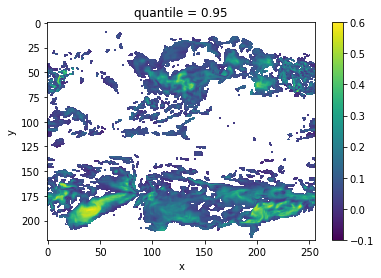

In [3]:
# calculate DPP with m=10
DPP10 = climpred.stats.dpp(control3d, m=10, chunk=False)
# calculate a threshold by random shuffling (based on bootstrapping with replacement at 95% significance level)
threshold = climpred.bootstrap.dpp_threshold(control3d, 
                                             m=10,
                                             chunk=False, 
                                             iterations=10,
                                             sig=95)
# plot grid cells where DPP above threshold
DPP10.where(DPP10 > threshold).plot(yincrease=False, vmin=-0.1, vmax=0.6, cmap='viridis')

Now, we can turn on chunking (the default for this function) to use the [Boer 2004] method. 

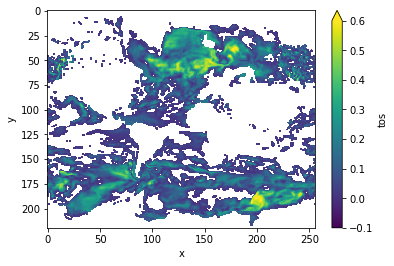

In [4]:
# chunk = True signals the Boer 2004 method
DPP10 = climpred.stats.dpp(control3d, m=10, chunk=True)
threshold = climpred.bootstrap.dpp_threshold(control3d, 
                                             m=10, 
                                             chunk=True, 
                                             iterations=10,
                                             sig=95)
DPP10.where(DPP10>0).plot(yincrease=False, vmin=-0.1, vmax=0.6, cmap='viridis')

### Variance-Weighted Mean Period
A periodogram is computed based on a control simulation to extract the mean period of variations, which are weighted by the respective variance. Regions with a high mean period value indicate low-frequency variations with are potentially predictable [Branstator2010].

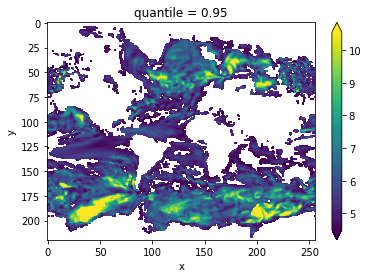

In [5]:
vwmp = climpred.stats.varweighted_mean_period(control3d, dim='time')
threshold = climpred.bootstrap.varweighted_mean_period_threshold(control3d, 
                                                             iterations=10)
vwmp.where(vwmp > threshold).plot(yincrease=False, robust=True)

### Lag-1 Autocorrelation
The lag-1 autocorrelation also indicates where slower modes of variability occur by identifying regions with high temporal correlation [vonStorch1999].

In [6]:
from esmtools.stats import autocorr

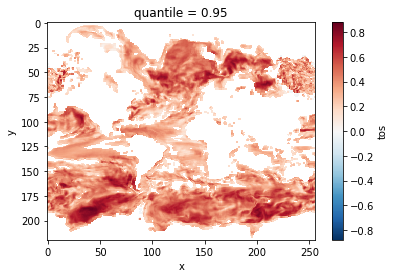

In [7]:
# use climpred.bootstrap._bootstrap_func to wrap any stats function. `esmtools.stats.autocorr` computes the autocorrelation
# coefficient out to N lags. The first lag is at lag 0, so we select `lead=1`).
threshold = climpred.bootstrap._bootstrap_func(autocorr, control3d, nlags=2, resample_dim='time', iterations=10).isel(lead=1)
corr_ef = autocorr(control3d, nlags=2, dim='time').isel(lead=1)
corr_ef.where(corr_ef>threshold).plot(yincrease=False, robust=False)

### Decorrelation time
Taking the lagged correlation further over all lags, the decorrelation time shows the time after which the autocorrelation fell beyond its e-folding [vonStorch1999]

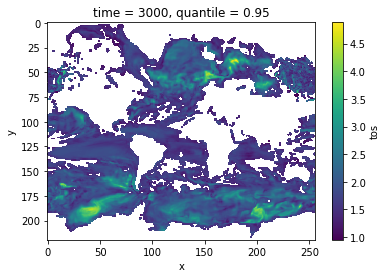

In [8]:
threshold = climpred.bootstrap._bootstrap_func(climpred.stats.decorrelation_time,control3d,'time',iterations=10)
decorr_time = climpred.stats.decorrelation_time(control3d)
decorr_time.where(decorr_time>threshold).plot(yincrease=False, robust=False)

### Verify diagnostic potential predictability in predictability simulations

Do we find predictability in the areas highlighted above also in perfect-model experiments?

In [9]:
ds3d = climpred.tutorial.load_dataset('MPI-PM-DP-3D')[varname].load()
ds3d['lead'].attrs['units'] = 'years'

In [10]:
bootstrap_skill = climpred.bootstrap.bootstrap_perfect_model(ds3d,
                                          control3d, 
                                          metric='rmse', 
                                          comparison='m2e',
                                          iterations=10)

In [11]:
init_skill = bootstrap_skill.sel(results='skill',kind='init')
# p value: probability that random uninitialized forecasts perform better than initialized
p = bootstrap_skill.sel(results='p',kind='uninit')

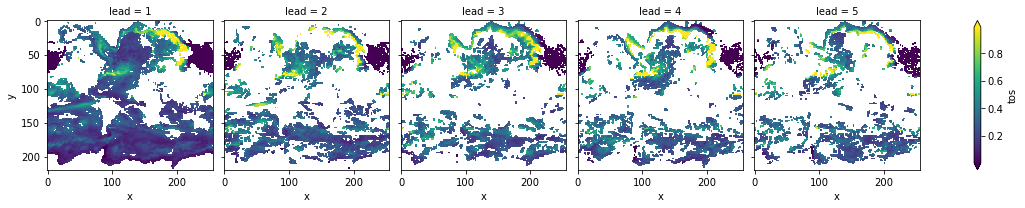

In [12]:
init_skill.where(p<=.05).plot(col='lead', robust=True, yincrease=False)

The metric `rmse` is negatively oriented, e.g. higher values show large disprepancy between members and hence less skill. 

As suggested by DPP, the variance-weighted mean period and autocorrelation, also in slight perturbed initial values ensembles there is predictability in the North Atlantic, North Pacific and Southern Ocean in sea-surface temperatures.

## References

1. Boer, Georges J. "Long time-scale potential predictability in an ensemble of coupled climate models." Climate dynamics 23.1 (2004): 29-44.
1. Resplandy, Laure, R. Séférian, and L. Bopp. "Natural variability of CO2 and O2 fluxes: What can we learn from centuries‐long climate models simulations?." Journal of Geophysical Research: Oceans 120.1 (2015): 384-404.
1. Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 
1. Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27, 2010): 6292–6311. https://doi.org/10/bwq92h.
1. Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate Research. Cambridge ; New York: Cambridge University Press, 1999.
